In this notebook imporoved the validation accuracy up to 0.787 by:

- using "glove-wiki-gigaword-300"
- training SVC with C=4 and rbf kernel

In [1]:
# Import packages
import re
import json
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

import umap
import matplotlib.pyplot as plt
import seaborn as sns

/Users/zhijiang/miniforge3/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# load the data
file_train = open("data/train.json", "r")
file_test = open("data/test.json", "r")
data_train = json.load(file_train)
data_test = json.load(file_test)

In [4]:
# make labels for training set
y_train = [recipe['cuisine'] for recipe in data_train]
y_train = pd.DataFrame(y_train, columns=['cuisine'])
y_train.head()

,cuisine
0,greek
1,southern_us
2,filipino
3,indian
4,indian


In [5]:
# Transform the labels into numerical values
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
label_encoder = label_encoder.fit(y_train.cuisine.astype(str))
y_train['cusine_code'] = label_encoder.transform(y_train.cuisine.astype(str)).astype(int)



In [6]:
y_train.head()

,cuisine,cusine_code
0,greek,6
1,southern_us,16
2,filipino,4
3,indian,7
4,indian,7


In [7]:
# train test split with random_state=330, this will be used later 
data_tt, data_val, y_tt, y_val = train_test_split(data_train,y_train,
                                                  test_size = .2,
                                                 shuffle=True,
                                                  random_state=330,
                                                 stratify=y_train['cusine_code'])

In [8]:
# load the word to vec model
import gensim.downloader as api
w2v_model = api.load("glove-wiki-gigaword-300")

In [9]:
# Creating the embedding vectors for data_train

embedding_dim = len(w2v_model.get_vector('hello'))
Data = np.zeros((len(data_train), embedding_dim))

for row in range(len(data_train)):
    ingredients = data_train[row]['ingredients']
    ingred_list = []
    for ingred in ingredients:
        ingred = ingred.lower()
        res = re.split('[^a-zA-Z0-9]+', ingred) 
        ingred_list.extend(res)
    
    Data[row] = w2v_model.get_mean_vector(ingred_list)
X_train = pd.DataFrame(Data)

In [10]:
X_train.head()

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,-0.007129,0.014538,0.037972,-0.002912,-0.019502,-0.035497,-0.035003,0.012690,0.009769,0.006574,...,-0.000511,0.002482,0.029561,-0.008820,-0.055830,-0.068829,-0.007445,-0.033466,0.033222,0.022508
1,-0.010825,0.037093,0.025090,-0.022936,-0.024930,-0.034393,-0.012253,0.026217,0.017413,-0.093013,...,-0.003094,0.003128,0.006862,0.020216,-0.008999,-0.022631,0.004138,-0.051838,0.006054,0.024809
2,-0.001878,0.025028,0.028985,-0.030870,-0.020794,-0.041656,-0.013798,0.023472,0.016664,-0.050984,...,-0.028241,0.010351,0.024706,-0.004655,-0.032478,-0.072424,0.007893,-0.048366,0.008881,0.026711
3,0.005193,0.016592,-0.005436,-0.032777,-0.012471,0.013311,-0.006194,0.015425,0.030766,-0.142578,...,-0.048216,-0.000493,0.015772,0.021818,0.045742,0.007719,0.003154,-0.094063,-0.018717,0.046306
4,-0.001775,0.033189,0.017418,-0.017050,-0.029041,-0.037277,-0.016641,0.008630,0.013647,-0.038315,...,-0.026515,0.010357,0.014744,-0.006545,-0.013195,-0.045015,0.010750,-0.030593,0.006772,0.042275


In [11]:
X_train.shape

(39774, 300)

In [12]:
# we use the same train_test_split with random_state=330
X_tt, X_val, y_tt, y_val = train_test_split(X_train, y_train, 
                                           test_size=0.2,
                                            shuffle=True,
                                           random_state=330,
                                           stratify=y_train['cusine_code'])

In [13]:
# svc with rbf kernel
svc = SVC(C=4, kernel = 'rbf')
svc.fit(X_tt, y_tt['cusine_code'])
svc_y_val_pred = svc.predict(X_val)
accuracy_score(y_val['cusine_code'], svc_y_val_pred)

0.7678189817724701

#### Now we apply PCA on the data before training model

In [14]:
# PCA
pca = PCA(0.99)
pca.fit(X_train.values)

X_train_pca = pca.transform(X_train.values)
X_train_pca.shape

(39774, 196)

In [15]:
# same train test split after pca
X_tt_pca, X_val_pca, y_tt, y_val = train_test_split(X_train_pca, y_train, 
                                           test_size=0.2,
                                            shuffle=True,
                                           random_state=330,
                                           stratify=y_train['cusine_code'])

In [19]:
# support vector classifier with rbf kernel
svc = SVC(C=1, kernel = 'rbf')
svc.fit(X_tt_pca, y_tt['cusine_code'])
svc_y_val_pred_pca = svc.predict(X_val_pca)
accuracy_score(y_val['cusine_code'], svc_y_val_pred_pca)

0.7723444374607166

In [23]:
# Hyperparameter tuning for C
C_list = [5, 8, 10, 15]
for C in C_list:
    svc = SVC(C=C, kernel = 'rbf')
    svc.fit(X_tt_pca, y_tt['cusine_code'])
    svc_y_val_pred_pca = svc.predict(X_val_pca)
    print("Accuracy for " + str(C) + 'is: ', accuracy_score(y_val['cusine_code'], svc_y_val_pred_pca))

Accuracy for 5is:  0.7839094908862351
Accuracy for 8is:  0.7802639849151477
Accuracy for 10is:  0.7777498428661219
Accuracy for 15is:  0.7758642363293526


In [24]:
# a refined tuning
C_list = [3, 4, 6, 7]
for C in C_list:
    svc = SVC(C=C, kernel = 'rbf')
    svc.fit(X_tt_pca, y_tt['cusine_code'])
    svc_y_val_pred_pca = svc.predict(X_val_pca)
    print("Accuracy for " + str(C) + ' is: ', accuracy_score(y_val['cusine_code'], svc_y_val_pred_pca))

Accuracy for 3 is:  0.7855436832181019
Accuracy for 4 is:  0.7873035826524198
Accuracy for 6 is:  0.7815210559396606
Accuracy for 7 is:  0.7806411062225016


In [16]:
# we use C=4 as the final choice
svc = SVC(C=4, kernel = 'rbf')
svc.fit(X_tt_pca, y_tt['cusine_code'])
svc_y_val_pred_pca = svc.predict(X_val_pca)
print("validation accuracy is: ", accuracy_score(y_val['cusine_code'], svc_y_val_pred_pca))

validation accuracy is:  0.7873035826524198


In [21]:
# a two dimensional visualization of the training data
reducer = umap.UMAP()
reducer.fit(X_tt_pca)
embedding = reducer.transform(X_tt_pca)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


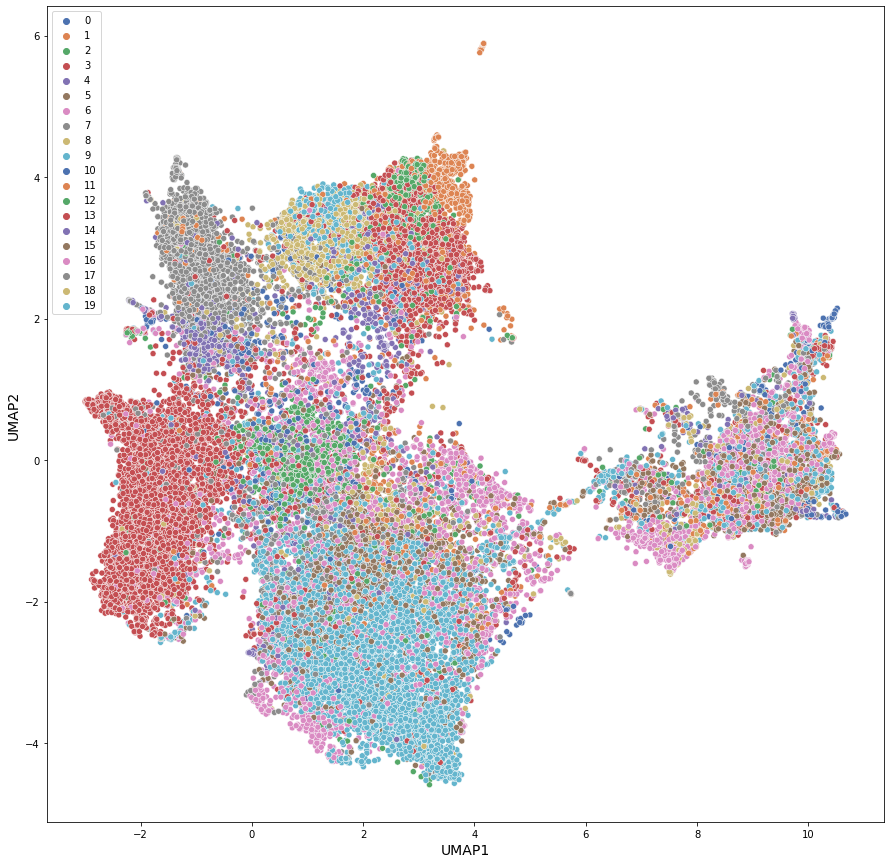

In [22]:
plt.figure(figsize=(15,15))
sns.scatterplot(x=embedding[:,0], y=embedding[:,1],
               hue = y_tt['cusine_code'],
               palette = 'deep')
plt.xlabel('UMAP1', fontsize=14)
plt.ylabel('UMAP2', fontsize=14)
plt.legend()
plt.show()